_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/GRB_ML)._

# openTSNE implementation in Swift Data
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we pre-process Swift Data and show how t-SNE implementation works. However, these implementations use only the manifold scikit Learn library. In this notebook, we use the [openTSNE](https://opentsne.readthedocs.io/en/latest/index.html) library to show how we can customize t-SNE at a high level. Through this document, we are using the _python3_ implementations from the _scripts_ folder. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the **main.py** file to our notebook (and some packages needed):

In [87]:
from scripts import main
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
import os  # Import os to handle folders and files
import numpy as np  # Import numpy module to read tables, manage data, etc

Then, create a new object from the `main.py` class and, if you need, set the data, table and results folder paths (by default it will be the "Data", "Table", and "Results" folders inside the path containing this notebook):

In [88]:
%matplotlib inline
object1 = main.SwiftGRBWorker()
object1.original_data_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Data\Original_Data'  # Change original data path
object1.table_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Tables'  # Change table path
object1.results_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Results'  # Change results path

## Changing the Swift GRB binning
By default, this notebook interpolates the data for high signal-to-noise ratio in Swift. There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ and _end_ variables.

Through this package, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $1$ for 1s binning and change the end variable to "sn5_10s" to use data with a signal-to-noise ratio higher than 5 or 10 s binning (these data don't have uniform time spacing).

In [89]:
object1.res = 64  # Resolution for the Light Curve Data in ms, could be 2, 8, 16, 64 (default), 256 and 1 (this last in s)
# object1.end = "sn5_10s"  # Uncomment this line if you need to use signal-to-noise higher than 5 or 10s binning

It is advisable not to change both variables at the same time; this could cause unknown bugs when running package routines and sub-routines. Additionally, you will need the data downloaded for the selected binning.

Last, from the pre-processing section, extract the GRB Names, pre-processed data and calculate durations:

In [90]:
data_loaded = np.load(os.path.join(object1.results_path, f"DFT_Preprocessed_data_{object1.end}.npz"))
GRB_names, features = data_loaded['GRB_Names'], data_loaded['Data']
durations_data_array = object1.durations_checker(GRB_names, t=90)  # Check for name, t_start, and t_end
start_times, end_times = durations_data_array[:, :, 1].astype(float), durations_data_array[:, :, 2].astype(float)
durations = np.reshape(end_times - start_times, len(durations_data_array))  # T_90 is equal to t_end - t_start

Finding Durations: 100%|██████████| 1318/1318 [00:09<00:00, 138.43GRB/s]


If you haven't pre-processed the data yet, check the _Data_Preprocessing_ notebook.

## Create a t-SNE Embedding:

A standard t-SNE optimization consists of five steps:
1. **Compute the affinities between data points**

In [91]:
%%time
affinities_train = affinity.PerplexityBasedNN(features, perplexity=30, metric="euclidean", n_jobs=os.cpu_count(), random_state=42, verbose=True)

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 46.23 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.14 seconds
CPU times: total: 1min 59s
Wall time: 46.4 s


2. **Generate initial coordinates for our embedding**
We can use _random_ and _PCA_ (Principal Component Analysis) to initialize an embedding. Additionally, we can use _median_ and _weighted_mean_ in an existing embedding. Actually, it is recommended to initialize an embedding using PCA:


In [92]:
init_train = initialization.pca(features, random_state=42, verbose=True)

===> Calculating PCA-based initialization...
   --> Time elapsed: 7.92 seconds


3. **Construct the ``TSNEEmbedding`` object**

In [93]:
embedding_train = TSNEEmbedding(init_train, affinities_train, negative_gradient_method="fft", n_jobs=os.cpu_count(), verbose=True, learning_rate=310)

4. **Optimize embedding**
* Early exaggeration phase

===> Running optimization with exaggeration=12.00, lr=310.00 for 250 iterations...
Iteration   50, KL divergence 2.6843, 50 iterations in 4.6563 sec
Iteration  100, KL divergence 2.6426, 50 iterations in 4.5874 sec
Iteration  150, KL divergence 2.6004, 50 iterations in 4.0546 sec
Iteration  200, KL divergence 2.5980, 50 iterations in 3.8594 sec
Iteration  250, KL divergence 2.5979, 50 iterations in 3.7344 sec
   --> Time elapsed: 20.89 seconds
CPU times: total: 47.7 s
Wall time: 21.3 s


<AxesSubplot:>

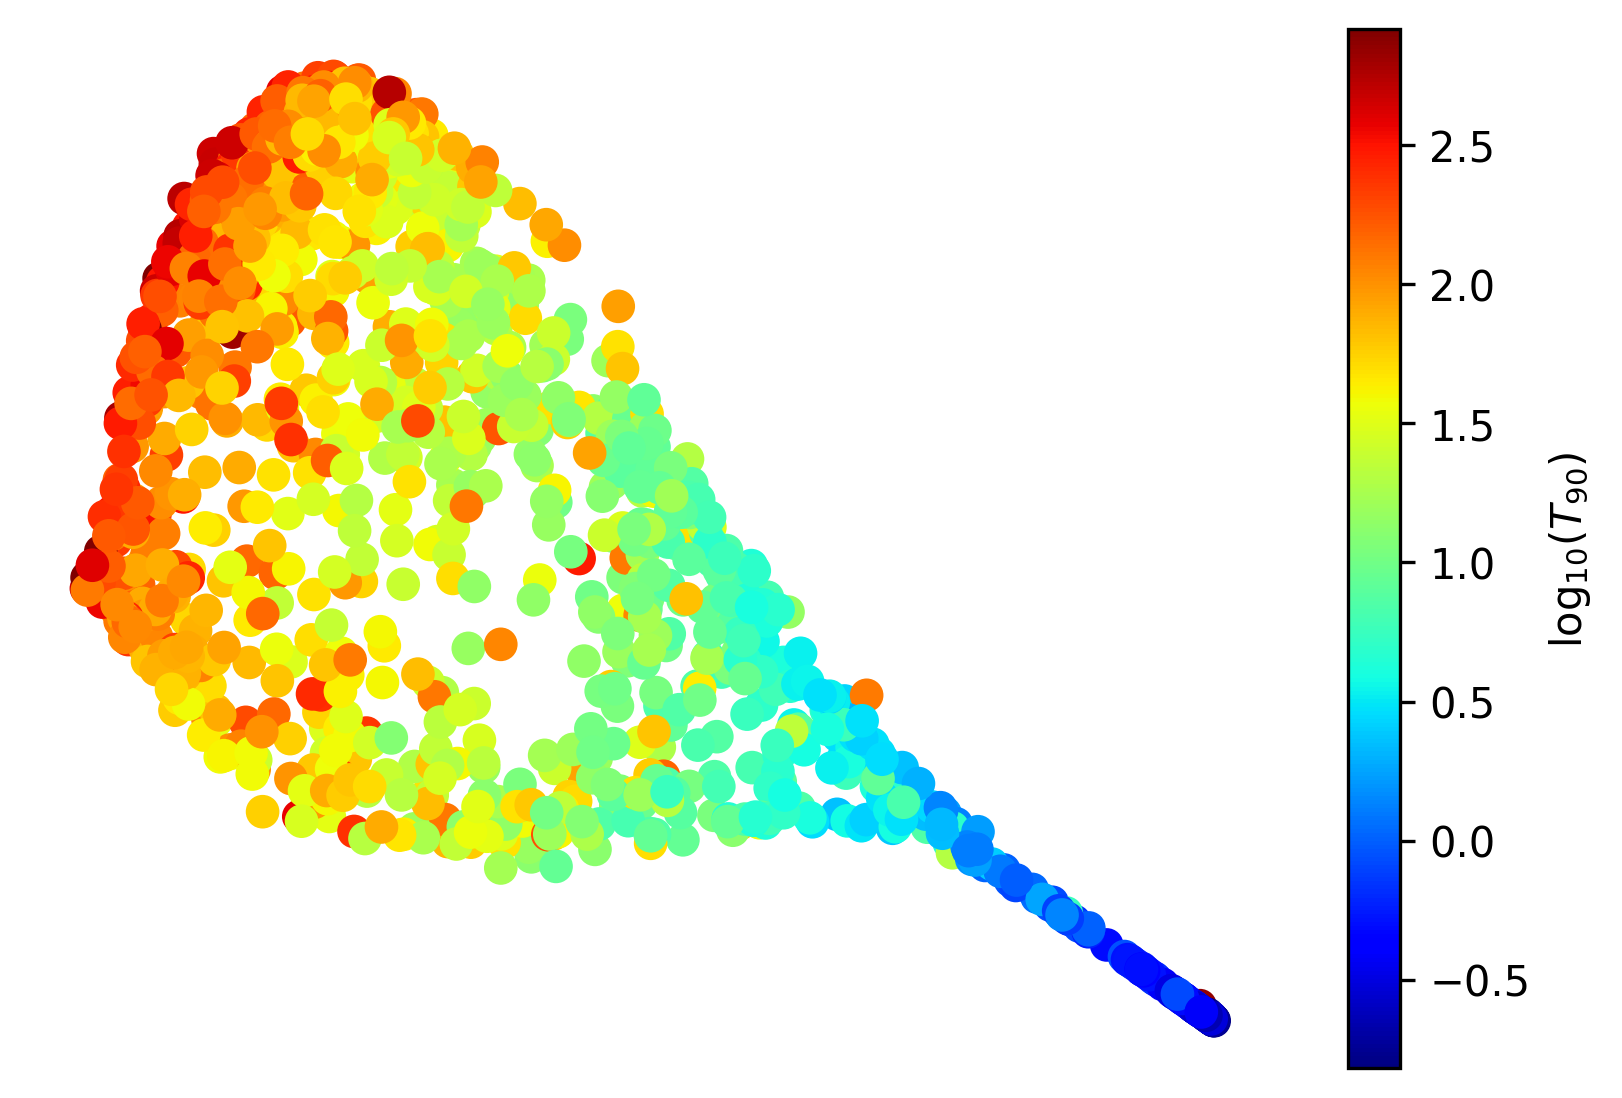

In [94]:
%%time
embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)
object1.tsne_scatter_plot(embedding_train_1, duration_s=durations)

* Regular optimization

===> Running optimization with exaggeration=1.00, lr=310.00 for 250 iterations...
Iteration   50, KL divergence 1.0718, 50 iterations in 3.8658 sec
Iteration  100, KL divergence 1.0082, 50 iterations in 3.5000 sec
Iteration  150, KL divergence 0.9940, 50 iterations in 3.5000 sec
Iteration  200, KL divergence 0.9904, 50 iterations in 4.1788 sec
Iteration  250, KL divergence 0.9890, 50 iterations in 4.4688 sec
   --> Time elapsed: 19.51 seconds
CPU times: total: 59.6 s
Wall time: 19.9 s


<AxesSubplot:>

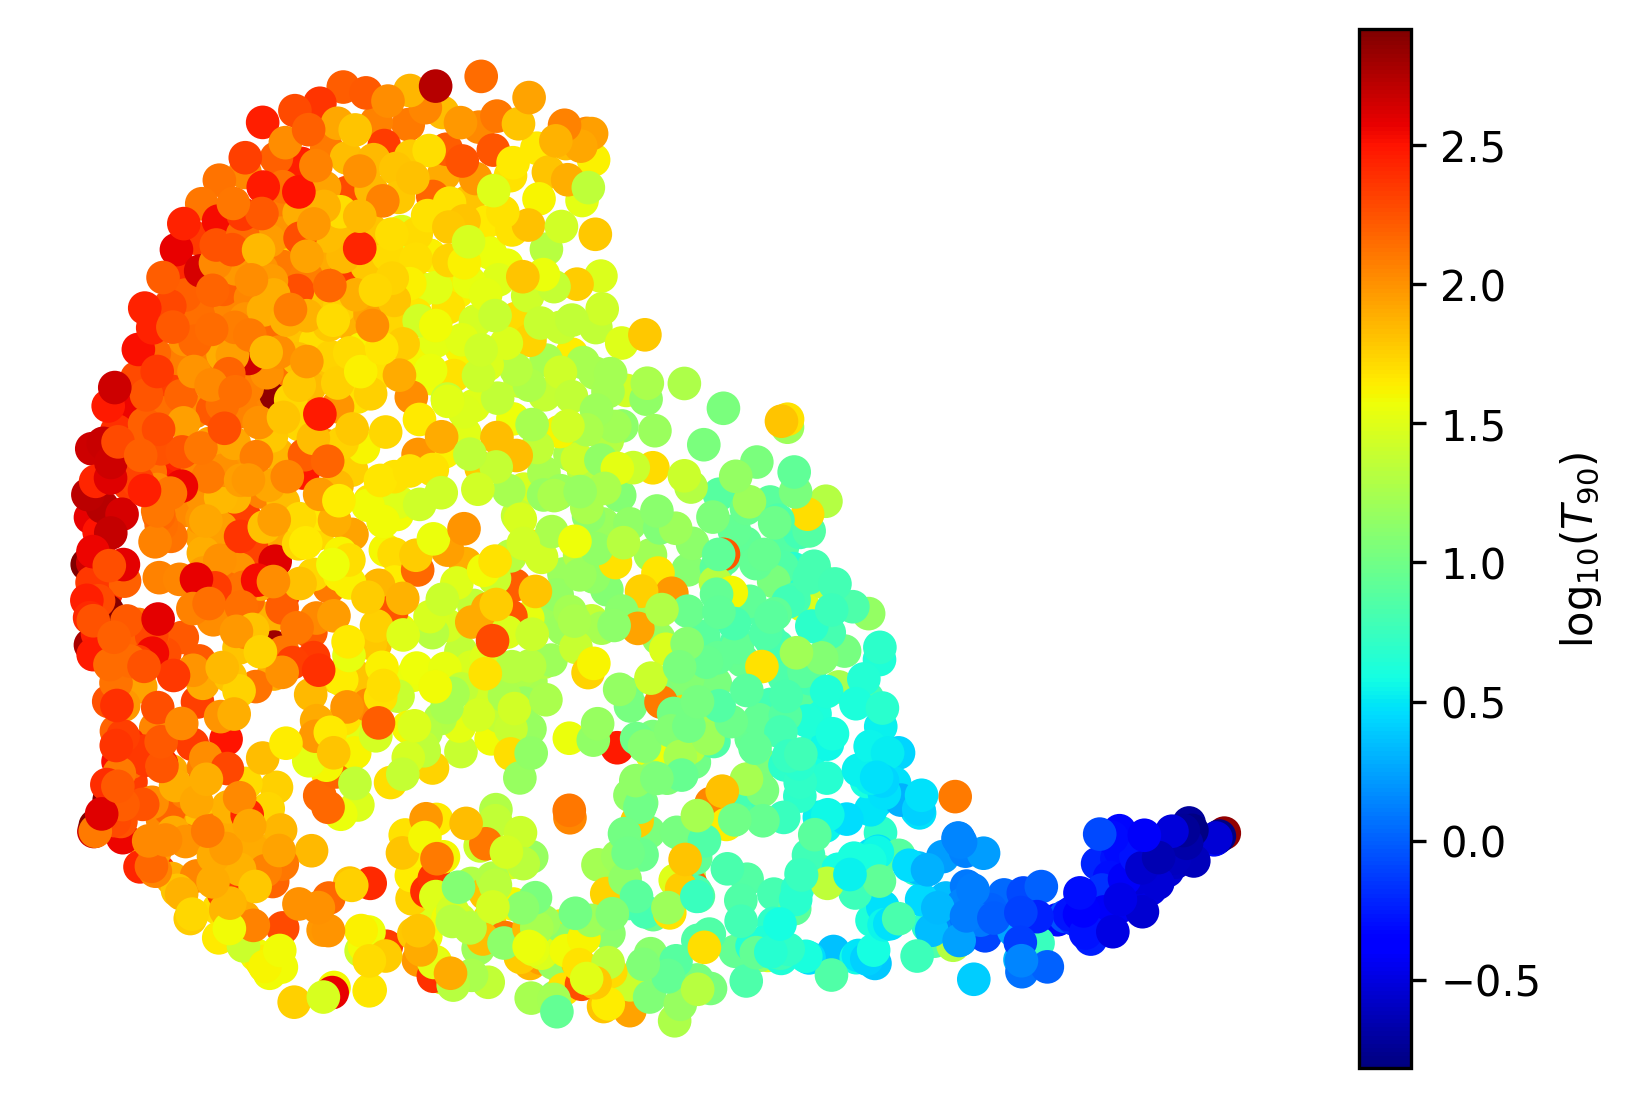

In [95]:
%%time
embedding_train_2 = embedding_train_1.optimize(n_iter=250, momentum=0.8)
object1.tsne_scatter_plot(embedding_train_2, duration_s=durations)

As you can see, the visualization map results depend critically on the early exaggeration phase results. Optimizing the early phase is crucial to getting reliable embeddings. Additionally, the embedding results don't change between libraries; consequently, there is a clear dependence between durations and the GRB light curves.

## Scikit results
By contrast, the same embedding using scikit Learn follows:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1318 samples in 0.141s...
[t-SNE] Computed neighbors for 1318 samples in 15.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1318
[t-SNE] Computed conditional probabilities for sample 1318 / 1318
[t-SNE] Mean sigma: 15.459952
[t-SNE] Computed conditional probabilities in 0.203s
[t-SNE] Iteration 50: error = 67.4639359, gradient norm = 0.2019131 (50 iterations in 1.953s)
[t-SNE] Iteration 100: error = 63.5712814, gradient norm = 0.1540928 (50 iterations in 1.172s)
[t-SNE] Iteration 150: error = 63.2341423, gradient norm = 0.1428854 (50 iterations in 0.969s)
[t-SNE] Iteration 200: error = 63.1460457, gradient norm = 0.1412006 (50 iterations in 1.313s)
[t-SNE] Iteration 250: error = 63.1607208, gradient norm = 0.1352570 (50 iterations in 1.000s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.160721
[t-SNE] Iteration 300: error = 1.1279193, gradient norm = 0.0004475 (50 iterations in 0.766

<AxesSubplot:>

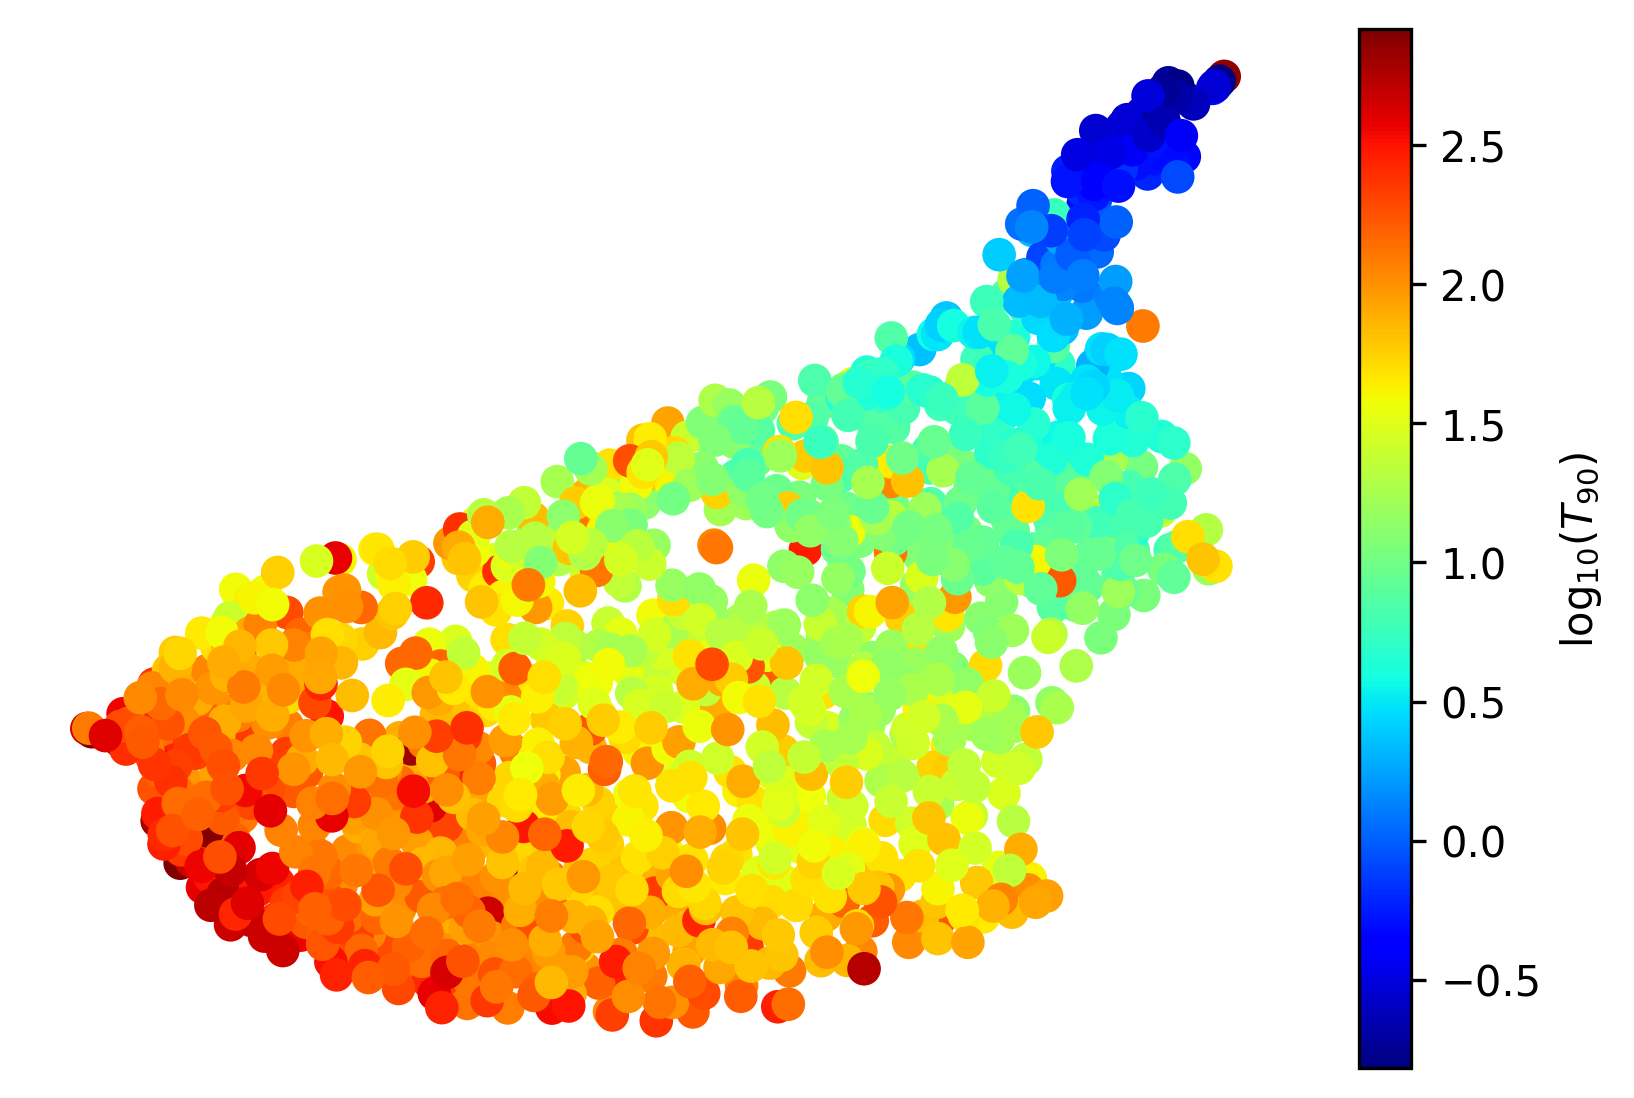

In [96]:
scikit_embedding = object1.perform_tsne(features, library='sklearn', perplexity=30, verbose=10)
object1.tsne_scatter_plot(scikit_embedding, duration_s=durations)